## Task 1 — Dataset Exploration (15 points)

In this task, we analyze the ECG training dataset to understand its structure and key characteristics. The primary goals are:

- Summarize the **class distribution** of the labels.
- Investigate the **lengths** of the time series.
- Compute basic **descriptive statistics** of the signals.
- Visualize representative **ECG waveforms** from each class.
- Identify characteristics that may help distinguish between classes.
- Construct a **validation split** that reflects the properties of the full dataset.

We aim to extract meaningful insights from the raw data that can guide downstream modeling decisions and provide justifications for architectural or preprocessing choices. These insights will also help ensure the validation set is representative and unbiased.

> Note: Each ECG signal is univariate and sampled at 300 Hz. The signals are stored in a binary format: a 32-bit integer indicating the signal length, followed by a sequence of 16-bit signed integers representing the values.


In [14]:
import sys
import os

# get the parent directory in order to work with python functions written outside the notebooks folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)


### Data Loading

In this section, we load the training signals from the binary `.bin` file using the provided parser. The data is encoded as a sequence of ECG signals, each prefixed by its length and stored in 16-bit signed integer format. We also load the corresponding class labels from the CSV file to prepare for further analysis.


In [ ]:
import src

# load training data
X_train = read_zip_binary("../data/X_train.zip")

# load training labels
y_train = pd.read_csv("../data/y_train.csv", header=None)
y_train.columns = ["y"]

print(f"Loaded {len(X_train)} ECG samples.")
#print(X_train[0])


Loaded 6179 ECG samples.
[-217, -246, -294, -344, -363, -371, -377, -379, -373, -361, -349, -337, -323, -306, -286, -263, -245, -228, -212, -192, -182, -177, -172, -167, -163, -159, -157, -155, -154, -154, -154, -156, -159, -163, -167, -171, -176, -180, -185, -189, -195, -202, -210, -217, -223, -227, -232, -236, -240, -243, -244, -246, -247, -248, -249, -250, -251, -251, -251, -251, -251, -251, -251, -251, -252, -252, -253, -253, -253, -252, -251, -249, -247, -245, -243, -240, -238, -235, -232, -230, -227, -223, -216, -207, -199, -195, -193, -192, -191, -191, -190, -189, -189, -189, -188, -187, -186, -184, -181, -178, -174, -171, -168, -165, -163, -161, -159, -156, -154, -152, -150, -148, -146, -143, -141, -139, -137, -136, -135, -133, -131, -129, -128, -127, -126, -125, -123, -121, -119, -116, -113, -110, -108, -107, -106, -105, -105, -105, -105, -105, -105, -104, -103, -102, -99, -96, -94, -91, -90, -89, -89, -87, -82, -75, -71, -70, -73, -77, -81, -84, -88, -92, -95, -95, -92, -86, 

### Class Distribution Analysis

We examine the distribution of class labels in the training set to understand class balance. This step is important for identifying potential sources of bias and deciding whether to apply techniques such as resampling, class weighting, or stratified splitting in later stages.

The ECG signals fall into four categories:
- Class 0: Normal
- Class 1: Atrial Fibrillation (AF)
- Class 2: Other rhythms
- Class 3: Noisy

A heavily imbalanced dataset may impact model performance and must be accounted for in both model training and evaluation.


Class distribution:
 y
0    3638
1     549
2    1765
3     227
Name: count, dtype: int64


/Users/cuzdu/Desktop/early-alzhemir-detection/env/lib/python3.12/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


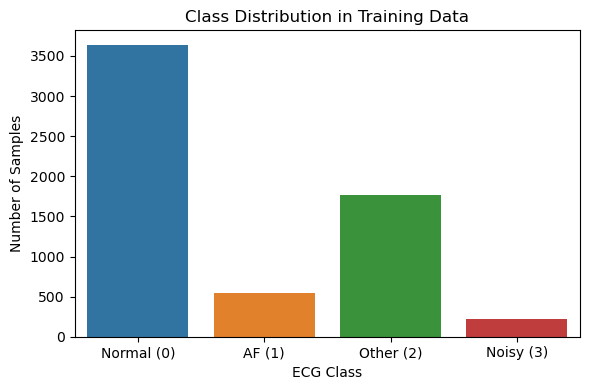

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# class distribution
class_counts = y_train["y"].value_counts().sort_index()
class_labels = ["Normal (0)", "AF (1)", "Other (2)", "Noisy (3)"]

print("Class distribution:\n", class_counts)

plt.figure(figsize=(6, 4))
sns.barplot(x=class_labels, y=class_counts.values)
plt.title("Class Distribution in Training Data")
plt.ylabel("Number of Samples")
plt.xlabel("ECG Class")
plt.tight_layout()
plt.show()

### Time Series Length Analysis

ECG signals in this dataset vary in length. Understanding the distribution of these lengths is important for preprocessing steps such as padding, truncation, or designing variable-length models.

In this section, we:
- Plot a histogram of signal lengths
- Compute basic statistics (min, max, mean, standard deviation)
- Optionally, analyze length distribution per class


Signal length statistics:
Min: 2714
Max: 18286
Mean: 9760.19
Std: 3292.19


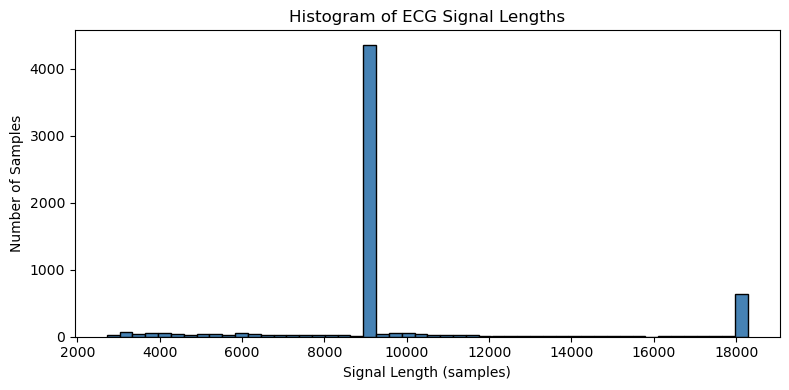

In [9]:
import numpy as np

# overall statistics (not class-wise)
signal_lengths = [len(sig) for sig in X_train]
signal_lengths = np.array(signal_lengths)

print("Signal length statistics:")
print(f"Min: {signal_lengths.min()}")
print(f"Max: {signal_lengths.max()}")
print(f"Mean: {signal_lengths.mean():.2f}")
print(f"Std: {signal_lengths.std():.2f}")

plt.figure(figsize=(8, 4))
plt.hist(signal_lengths, bins=50, color="steelblue", edgecolor="black")
plt.title("Histogram of ECG Signal Lengths")
plt.xlabel("Signal Length (samples)")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()

### Observations on Signal Lengths and Outliers

From the class-wise signal length statistics, we observe that the vast majority of ECG signals in classes 0, 1, and 2 have a fixed length of exactly 9000 samples (see below). This is evident from the identical values at the 25th, 50th, and 75th percentiles for those classes.

In contrast, class 3 (Noisy) displays more variability in signal lengths, with a notably lower average and a wider range. Some outliers with very short or long lengths are also present in other classes, though rare.

At this stage, we choose not to remove these outliers. They may contain valuable or unique information, and their impact on model training can be better assessed during the preprocessing and modeling phases. Most models will require padding or trimming to handle variable-length sequences consistently, which can be addressed later in the pipeline.


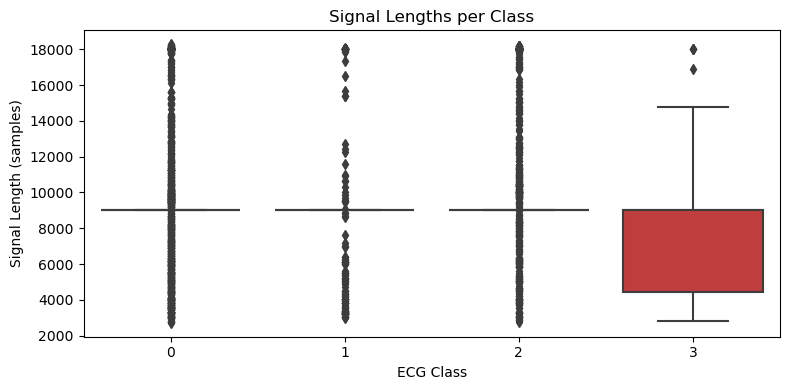

Class-wise length statistics:
        count          mean          std     min     25%     50%     75%  \
label                                                                      
0      3638.0   9662.820781  3020.082853  2714.0  9000.0  9000.0  9000.0   
1       549.0   9510.863388  3623.816247  2996.0  9000.0  9000.0  9000.0   
2      1765.0  10366.379603  3573.787232  2738.0  9000.0  9000.0  9000.0   
3       227.0   7210.215859  2883.541197  2808.0  4456.0  9000.0  9000.0   

           max  
label           
0      18286.0  
1      18062.0  
2      18188.0  
3      18000.0  


In [10]:
length_df = pd.DataFrame({
    "length": signal_lengths,
    "label": y_train["y"]
})

# signal lengths per class
plt.figure(figsize=(8, 4))
sns.boxplot(data=length_df, x="label", y="length")
plt.title("Signal Lengths per Class")
plt.xlabel("ECG Class")
plt.ylabel("Signal Length (samples)")
plt.tight_layout()
plt.show()

# class-wise statistics
class_stats = length_df.groupby("label")["length"].describe()
print("Class-wise length statistics:")
print(class_stats)

### Sample ECG Signal per Class

The following figure shows one randomly selected ECG signal from each class. This allows for a quick visual comparison of waveform shape, amplitude, and overall signal characteristics across classes.


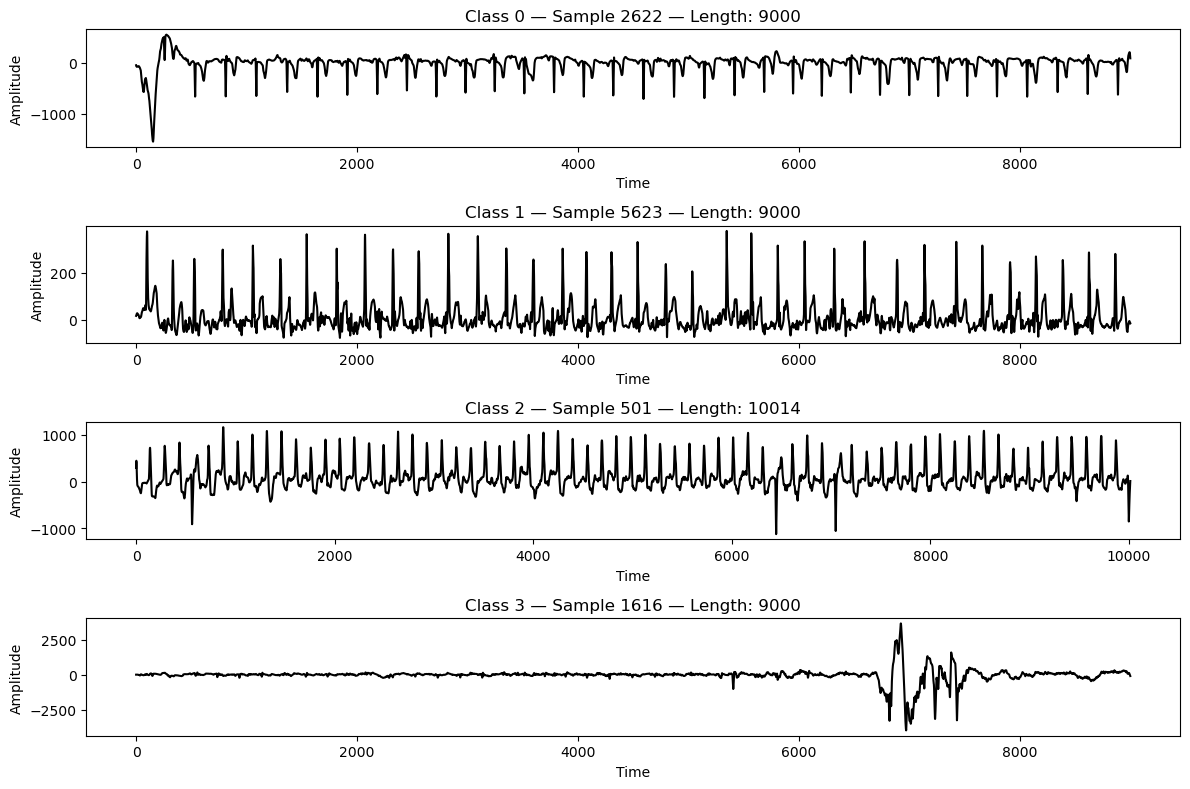

In [11]:
plt.figure(figsize=(12, 8))

for i, class_id in enumerate(sorted(y_train["y"].unique())):
    idx = np.random.choice(np.where(y_train["y"] == class_id)[0])
    plt.subplot(4, 1, i + 1)
    plt.plot(X_train[idx], color="black")
    plt.title(f"Class {class_id} — Sample {idx} — Length: {len(X_train[idx])}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

### Validation Split with Stratified Sampling

To evaluate our model fairly during training, we create a validation set using stratified sampling. This ensures that the class proportions in the training and validation subsets closely match those of the original dataset.

This is especially important in our case, as the ECG dataset is pretty imbalanced (e.g. with significantly more samples in class 0 compared to classes 1 and 3). A simple random split could accidentally overrepresent or underrepresent minority classes in the validation set, leading to biased performance estimates.

Training set size: 4943
Validation set size: 1236


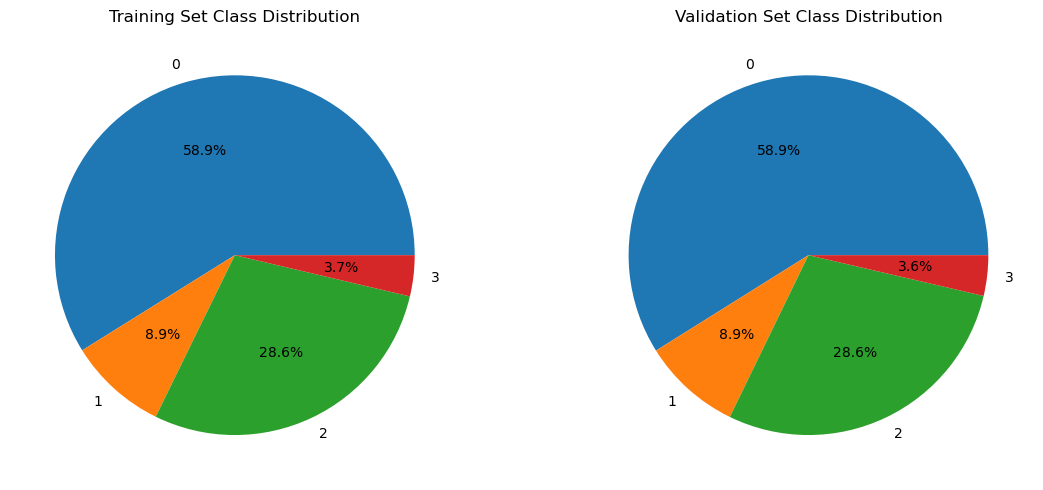

In [ ]:
from src.split import create_stratified_split

train_idx, val_idx = create_stratified_split(X_train, y_train, val_size=0.2)

print(f"Training set size: {len(train_idx)}")
print(f"Validation set size: {len(val_idx)}")

# visualize class balance

# label splitting
y_train_split = y_train.iloc[train_idx]
y_val_split = y_train.iloc[val_idx]

# counting class occurence
train_counts = y_train_split["y"].value_counts().sort_index()
val_counts = y_val_split["y"].value_counts().sort_index()
labels = ["0", "1", "2", "3"]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# autopct param to include percentages to single decimal point
axes[0].pie(train_counts, labels=labels, autopct="%1.1f%%")
axes[0].set_title("Training Set Class Distribution")

axes[1].pie(val_counts, labels=labels, autopct="%1.1f%%")
axes[1].set_title("Validation Set Class Distribution")

plt.tight_layout()
plt.show()


In [21]:
# save splits for later use
np.save("../data/train_idx.npy", train_idx)
np.save("../data/val_idx.npy", val_idx)